In [1]:
%matplotlib inline

/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:1041: UserWarning: Duplicate key in file "/home/cloud-user/.config/matplotlib/stylelib/paper.mplstyle", line #9
  (fname, cnt))


In [2]:
import os
import pickle as pkl
import numpy as np
from matplotlib import pyplot as plt

from viz_helpers import set_cycler
from helpers import makedir_if_not_there
from itertools import product

## Usage
- `mode`:"cmp-baseline" if evaluating on nodes and  "edge-cmp-baseline" if evaluating on edges

In [3]:
# mode = 'cmp-baseline'
# mode = 'root_selection'
if True:
    mode = 'edge-cmp-baseline'
    EVAL_DIR = 'eval-edges'
else:
    mode = 'cmp-baseline'
    EVAL_DIR = 'eval'
WITH_TITLE = False

In [4]:
# graphs = ['lattice-1024', 'infectious', 'grqc']
graphs = ['lattice-1024', 'infectious', 'email-univ', 'fb-messages', 'grqc']
obs_method = 'uniform'
models = ['ic', 'si']
if mode == 'root_selection':
    methods = ['our', 'our-min_dist', 'our-pagerank', 'our-true_root']
elif mode == 'cmp-baseline':
    methods = [ 'min-steiner-tree', 'netfill', 'pagerank', 'our-true_root', 'our-min_dist']
elif mode == 'edge-cmp-baseline':
    methods = ['our-min_dist', 'our-true-root',  'min-steiner-tree']
print(methods)

['our-min_dist', 'our-true-root', 'min-steiner-tree']


In [5]:
plt.style.use('paper')

In [6]:
def iter_through_obs_fraction(method, graph, model, cascade_fraction, obs_fractions):
    return ['{}/{}/{}-m{}-s{}-o{}-om{}.pkl'.format(EVAL_DIR, method, graph, model, cascade_fraction, obs_fraction, obs_method)
            for obs_fraction in obs_fractions]

In [7]:
def iter_through_cascade_fraction(method, graph, model, obs_fraction, cascade_fractions):
    return ['{}/{}/{}-m{}-s{}-o{}-om{}.pkl'.format(EVAL_DIR, method, graph, model, cascade_fraction, obs_fraction, obs_method)
            for cascade_fraction in cascade_fractions]

In [8]:
def load_batch(paths):
    data = []
    for path in paths:
        try:
            d = pkl.load(open(path, 'rb')) 
        except IOError:
            print('warning: fail to load {}'.format(path))
            d = {}
        data.append(d)
    return data

In [9]:
def extract_batch(objs, extractor=lambda s: s.get('50%')):
    return [extractor(o) for o in objs]

In [10]:
def together(*args, path_iter_func=None, **kwargs):
    assert path_iter_func is not None
    return extract_batch(load_batch(path_iter_func(*args, **kwargs)))

In [11]:
def load_data_along_one_dimension(graph, model, dim1_vars,
                                  path_iter_func,
                                  **kwargs):
    rows = []
    for v in dim1_vars:
        row = together(v, graph, model,
                       path_iter_func=path_iter_func,
                       **kwargs)
        rows.append(row)
    return rows

In [12]:
def plot(rows, dim1_vars, dim2_vars, xlabel, ylabel, title=None, output=None):
    fig, ax = plt.subplots(1, 1)    
    set_cycler(ax)
    for r in rows:
        ax.plot(dim2_vars, r, alpha=0.9)
    # ax.legend(dim1_vars, loc='best')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)    
    ax.locator_params(nbins=4, axis='x')    
    ax.locator_params(nbins=4, axis='y')
    fig.tight_layout()
    
    if WITH_TITLE and title is not None:
        ax.set_title(title)
    
    if output is not None:
        fig.savefig(output)

lattice-1024 ic
[[0.5970943105097373, 0.6067265574131839, 0.6073954687535006, 0.6064620440051115, 0.6074861128979914], [0.5988037470401764, 0.6066075748925563, 0.60701714220907, 0.6047037042942798, 0.6072996196985463], [0.33106637636689934, 0.33587339351842804, 0.3502112044960434, 0.35487017109800734, 0.3704199746336285]]
lattice-1024 si
[[0.5638739605217304, 0.5390910859094957, 0.534445330582493, 0.5301184281349716, 0.5284041429255292], [0.5659206428080805, 0.5421144166085811, 0.5358626958804453, 0.5269147694980452, 0.5283638015213479], [0.20777863116572795, 0.20690692993850873, 0.2190508031469402, 0.2387090181651843, 0.2531634732084403]]
infectious ic
[[0.18537939902219702, 0.1972876490867476, 0.20486293724849924, 0.21516457490575336, 0.22896163310403628], [0.17875849450903647, 0.1971264735964513, 0.20323343687176404, 0.21376108173065245, 0.22918263540018677], [0.023625657663260045, 0.036842678937491546, 0.0485823284272197, 0.054685145676499514, 0.06396189094814585]]
infectious si
[[

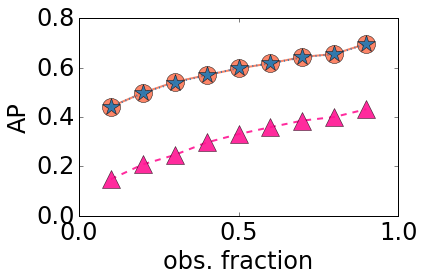

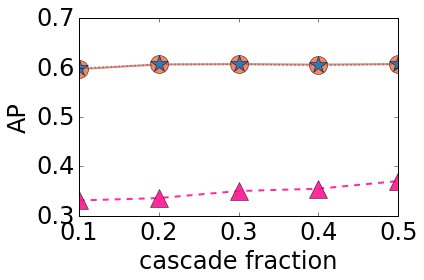

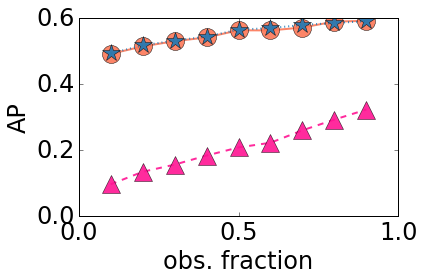

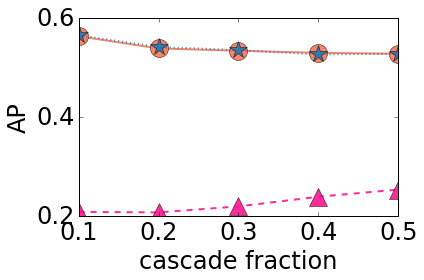

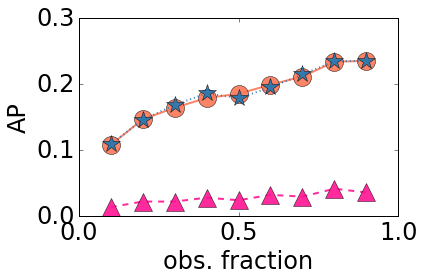

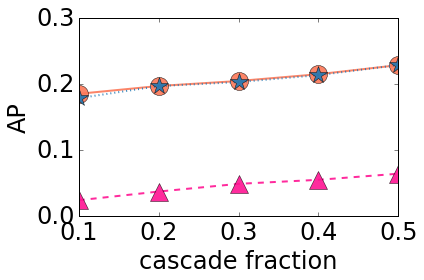

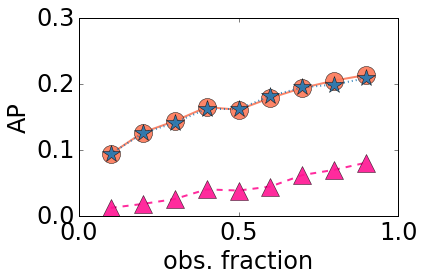

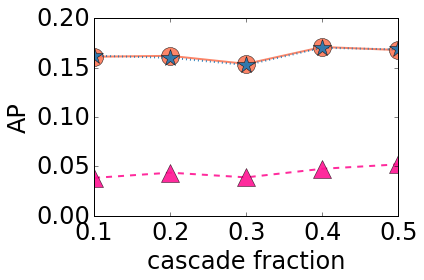

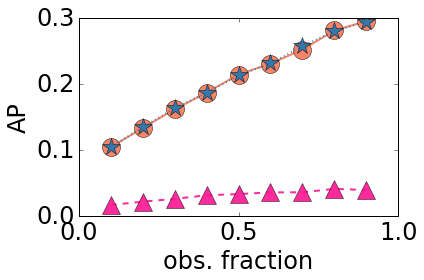

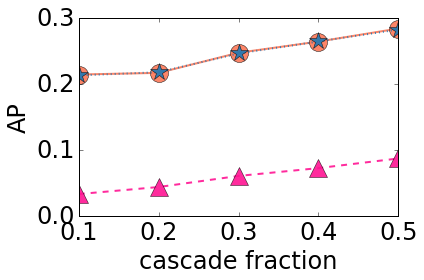

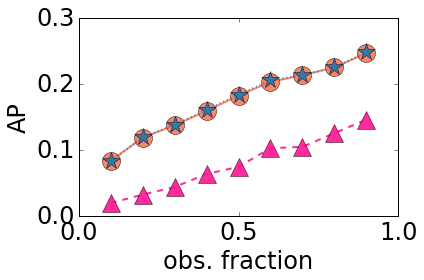

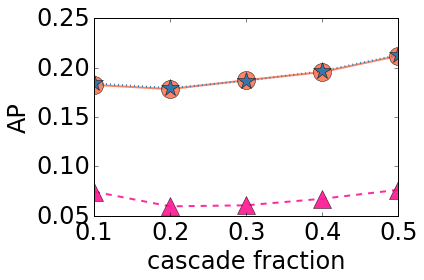

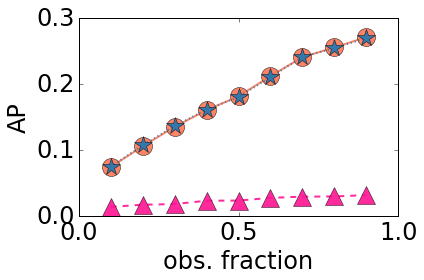

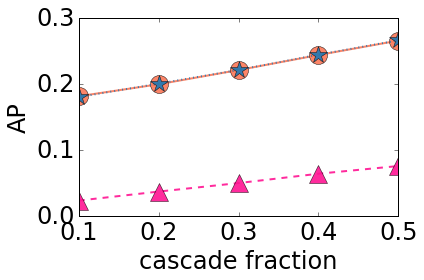

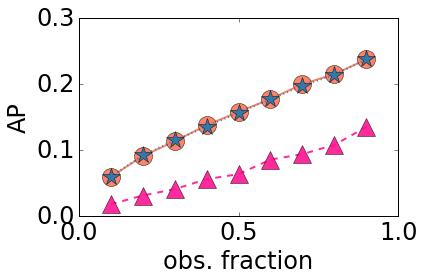

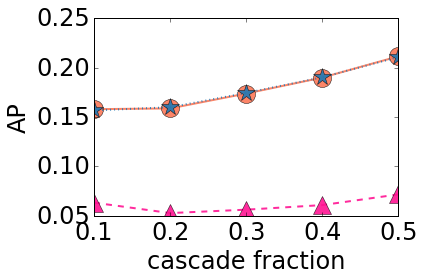

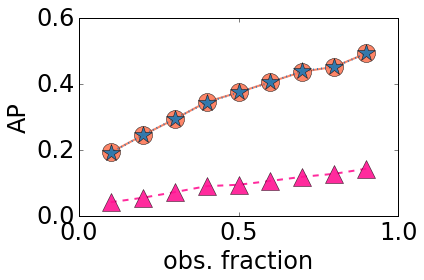

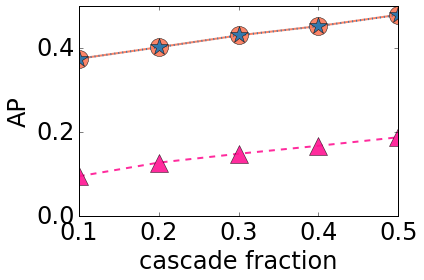

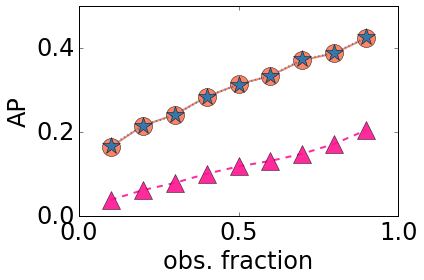

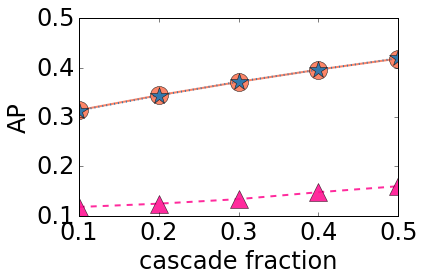

In [13]:
for graph, model in product(graphs, models):
    #########
    # vary over obs fractions
    ########
    print(graph, model)
    output_dir = 'figs/{}-obs-fractions'.format(mode)
    makedir_if_not_there(output_dir)

    cascade_fraction = '0.1'
    
    obs_fractions = ["0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9"]

    kwargs = {'cascade_fraction': cascade_fraction,
              'obs_fractions': obs_fractions}
    rows = load_data_along_one_dimension(graph, model, methods, 
                                         iter_through_obs_fraction, 
                                         **kwargs)
    fig_name = '{}-m{}.pdf'.format(graph, model)
    plot(rows, methods, obs_fractions, 'obs. fraction', 'AP', graph,
         output=os.path.join(output_dir, fig_name))

    #########
    # vary over cascade fractions
    #########

    # output_dir = 'figs/different-cascade-fractions-om{}'.format(obs_method)
    output_dir = 'figs/{}-cascade-fractions'.format(mode)
    makedir_if_not_there(output_dir)

    cascade_fractions = ["0.1", "0.2", "0.3", "0.4", "0.5"]
        
    obs_fractions = ['0.5']
    kwargs = {'cascade_fractions': cascade_fractions,
              'obs_fraction': 0.5}
    rows = load_data_along_one_dimension(graph, model, methods, 
                                         iter_through_cascade_fraction, 
                                         **kwargs)
    print(rows)
    plot(rows, methods, list(map(float, cascade_fractions)), 'cascade fraction', 'AP', graph,
         output=os.path.join(output_dir, fig_name))

[0.009081360204650729, 0.010695512597108693, 0.012013077984375307, 0.012523287836582435, 0.013673145567028113, 0.013538755599003853, 0.015058188798622271, 0.013712393683121205]
[0.06745960736929164, 0.06393377558036643, 0.05882696873359554, 0.051491030315281544, 0.043139848831703485, 0.03582725031785937, 0.027678756910127042, 0.01935574856986852]
[0.060268531551388796, 0.060284816031216576, nan, nan, nan, 0.045770313131497306, 0.04000345600715443, 0.03034356563185716]
[0.0608915982823673, 0.06204742453610436, 0.06102147154334793, 0.05717435900586816, 0.05261257805022222, 0.04570453880817616, 0.04045435979278762, 0.030447211839901494]


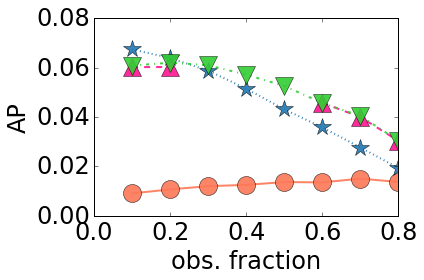

In [19]:
def iter_through_obs_fraction(method, graph, obs_fractions):
    return ['{}/{}/{}-o{}-om{}.pkl'.format(EVAL_DIR, method, graph, obs_fraction, obs_method)
            for obs_fraction in obs_fractions]

def load_data_along_one_dimension(graph, dim1_vars,
                                  path_iter_func,
                                  **kwargs):
    rows = []
    for v in dim1_vars:
        row = together(v, graph,
                       path_iter_func=path_iter_func,
                       **kwargs)
        print(row)
        rows.append(row)
    return rows

EVAL_DIR = 'eval'
graph = 'digg'
methods = ['min-steiner-tree', 'pagerank', 'our-pagerank', 'our-true_root']
output_dir = 'figs/digg'.format(mode)
makedir_if_not_there(output_dir)

obs_fractions = ["0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8"]

kwargs = {'obs_fractions': obs_fractions}
rows = load_data_along_one_dimension(graph, methods, 
                                     iter_through_obs_fraction, 
                                     **kwargs)
fig_name = '{}.pdf'.format(graph)
plot(rows, methods, obs_fractions, 'obs. fraction', 'AP', graph,
     output=os.path.join(output_dir, fig_name))